In [1]:
import pickle
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution


In [2]:
def run_flayer_case(input_data, filename=None):
    """
    Run a single f-layer case with input from dictionary, optionally save
    
    input_data: a dictionary of input data 
    filename: optional string, if present save case to file
    
    Returns
    output_data: a dictionary of input and output data"""
    
    solutions, analysis_radii, particle_densities, calculated_seperation, solid_vf, \
        particle_radii, partial_particle_densities, growth_rate, opt_xl, crit_nuc_radii, nucleation_rates \
        = flayer.flayer_case(**input_data)
    
    output_data = dict(input_data)
    
    output_data["solutions"] = solutions
    output_data["analysis_radii"] = analysis_radii
    output_data["particle_densities"] = particle_densities
    output_data["calculated_seperation"] = calculated_seperation
    output_data["solid_vf"] = solid_vf
    output_data["particle_radii"] = particle_radii
    output_data["partial_particle_densities"] = partial_particle_densities
    output_data["growth_rate"] = growth_rate
    output_data["opt_xl"] = opt_xl
    output_data["crit_nuc_radii"] = crit_nuc_radii
    output_data["nucleation_rates"] = nucleation_rates
    
    if filename is not None:
        with open(filename, 'wb') as f:
            pickle.dump(output_data, f)
    
    return output_data


def plot_case_single_solution(index, data):
    """
    Create plot of time evolution for nucleation from a single depth, given case data and index
    
    index: integer nucleation index
    data: dictioary of compleated f-layer case. If a string read from pickle file
    """
    if isinstance(data, str):
        with open(data, 'rb') as f:
            data = pickle.load(f)
            
    tfunc, tafunc, xfunc, pfunc, gfunc = flayer.setup_flayer_functions(**data)
    xl_func = spi.interp1d(data["analysis_radii"], data["opt_xl"], fill_value='extrapolate')

    particle_evolution.plot_particle_evolution_time(data["solutions"][index], xl_func, tfunc, pfunc, data['chemical_diffusivity'],
                                                    data['growth_prefactor'], gfunc, data['kinematic_viscosity'])

/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)
/Users/andrewwalker/Code/slurry/falling.py:165: RuntimeWarning: invalid value encountered in double_scalars
  delta_u = (fr/re)**(0.5) * 2.0 * radius
/Users/andrewwalker/Code/slurry/falling.py:171: RuntimeWarning: invalid value encountered in double_scalars
  delta_c = fr**(1/6) / (re**(1/6) * pe_c**(1/6)) * 2.0 * radius
/Users/andrewwalker/Code/slurry/falling.py:172: RuntimeWarning: invalid value encountered in double_scalars
  delta_t = fr**(1/6) / (re**(1/6) * pe_t**(1/6)) * 2.0 * radius
/Users/andrewwalker/Code/slurry/falling.py:165: RuntimeWarning: invalid value encountered in double_scalars
  delta_u = (fr/re)**(0.5) * 2.0 * radius
/Users/andrewwalker/Code/slurry/falling.py:171: RuntimeWarning: invalid value encountered in double_scalars
  delta_c = fr**(1/6) / (re**(1/6) * pe_c**(1

Done, inner core growth rate is 16.334134700690484 km/Myr


/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


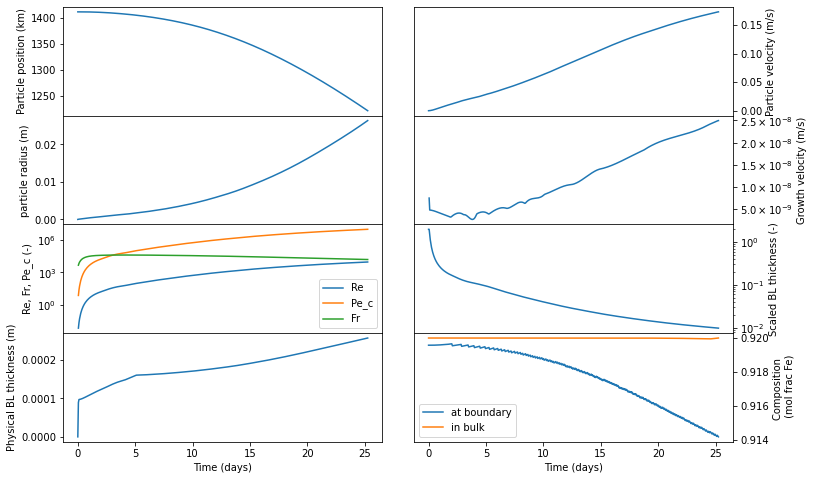

In [3]:
input_parameters = {'f_layer_thickness': 200.0E3,
                    'delta_t_icb': 10.0,
                    'xfe_outer_core': 0.92,
                    'xfe_icb': 0.92,
                    'growth_prefactor': 150.0,
                    'chemical_diffusivity': 1.0E-9,
                    'kinematic_viscosity': 1.0E-6,
                    'i0': 1.0E-10,
                    'surf_energy': 1.08E-2, 
                    'number_of_analysis_points': 20,
                    'r_icb': 1221.5E3, 
                    'r_cmb': 3480.0E3,
                    'gruneisen_parameter': 1.5}

data = run_flayer_case(input_parameters, "data.pickle")



print("Done, inner core growth rate is", data["growth_rate"], "km/Myr")

plot_case_single_solution(-2, "data.pickle")